# Stem Cell Model

From Brady et al.

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


sys.path.append("../utils")
from odeModels import StemCellModel, StemCellModel2
from plotUtils import PlotSimulation


In [2]:
# Defaults for plotting
plt.style.use(["classic", "../utils/paper.mplstyle"])
plt.rcParams['font.size'] = '18'

colors = {'Sensitive': '#4c9150', 'Resistant': '#a80303', 'CT':'#c28d32' , 'AT':'#143159' ,'DRL_Monthly':'#66419e'}

## Model Simulations

In [3]:
# Patient 1002 - TTP ~ 3000 days
stemParamDic2 = {'rR': np.log(2),'beta': 0.025, 'dR': 0.4852,  # Cell params
                'rho': 0.0025, 'phi': 0.0167, 'DMax': 1,  # PSA/Drug params
                'S0': 1000, 'R0': 10, 'P0': 58.57}  # Initial conditions
# Patient 1005 - TTP ~ 3000 days
stemParamDic5 = {'rR': np.log(2),'beta': 0.0276, 'dR': 0.3205,  # Cell params
                'rho': 0.0016, 'phi': 0.0068, 'DMax': 1,  # PSA/Drug params
                'S0': 1000, 'R0': 10, 'P0': 95.86}  # Initial conditions
# Patient 1010 - TTP ~ 300 days
stemParamDic10 = {'rR': np.log(2),'beta': 0.3332, 'dR': 0.0958,  # Cell params
                'rho': 6.548e-5, 'phi': 0.0028, 'DMax': 1,  # PSA/Drug params
                'S0': 1000, 'R0': 10, 'P0': 17.33}  # Initial conditions
# Patient 1014 - TTP ~ 2000 days
stemParamDic14 = {'rR': np.log(2),'beta': 0.0425, 'dR': 0.0478,  # Cell params
                'rho': 1.243e-04, 'phi': 0.0113, 'DMax': 1,  # PSA/Drug params
                'S0': 1000, 'R0': 10, 'P0': 11.83}  # Initial conditions
# Patient 1018 - TTP ~ 800 days
stemParamDic18 = {'rR': np.log(2),'beta': 0.1208, 'dR': 0.2083,  # Cell params
                'rho': 4.931e-04, 'phi': 0.0149, 'DMax': 1,  # PSA/Drug params
                'S0': 1000, 'R0': 10, 'P0': 36.54}  # Initial conditions

Mean TTP for Stem Cell Model under Continuous Therapy is 1095 days


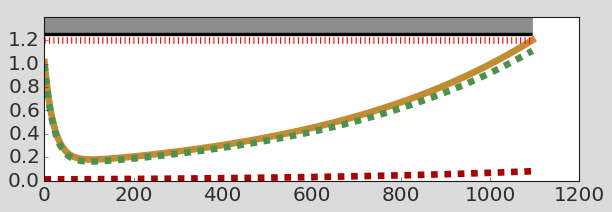

In [4]:
fig, ax = plt.subplots(1,1,figsize=(8,3))
stemParamDic = stemParamDic14
stemParamDic['N0'] = stemParamDic['S0'] + stemParamDic['R0']

model = StemCellModel(method='Radau', dt = 1)
model.SetParams(**stemParamDic)
model.Simulate_AT(atThreshold=0.05, intervalLength=1, t_end=10000)
model.Trim(dt=1)
model.resultsDf[['TumourSize', 'S', 'R']] /= (stemParamDic['S0'] + stemParamDic['R0'])
model.resultsDf = model.resultsDf[model.resultsDf.TumourSize < 1.2]

print(f"Mean TTP for Stem Cell Model under Continuous Therapy is {max(model.resultsDf.Time):.0f} days")

palette = {'TumourSize': colors["CT"], 'S': colors['Sensitive'], 'R': colors['Resistant']}
PlotSimulation(model.resultsDf, ax=ax, legend=False, colors = palette, linewidth = 6)

# plt.savefig("figures/figSI_SC_AT.pdf")

Mean TTP for Stem Cell Model under Continuous Therapy is 2235 days


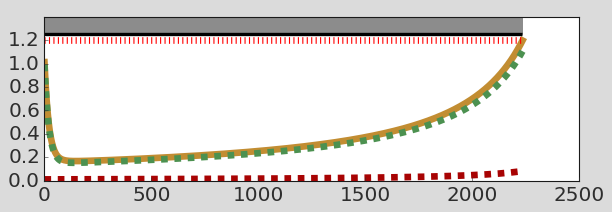

In [5]:
fig, ax = plt.subplots(1,1,figsize=(8,3))
stemParamDic = stemParamDic14
stemParamDic['N0'] = stemParamDic['S0'] + stemParamDic['R0']

model = StemCellModel2(method='Radau', dt = 1)
model.SetParams(**stemParamDic)
model.Simulate_AT(atThreshold=0.05, intervalLength=1, t_end=10000)
model.Trim(dt=1)
model.resultsDf[['TumourSize', 'S', 'R']] /= (stemParamDic['S0'] + stemParamDic['R0'])
model.resultsDf = model.resultsDf[model.resultsDf.TumourSize < 1.2]

print(f"Mean TTP for Stem Cell Model under Continuous Therapy is {max(model.resultsDf.Time):.0f} days")

palette = {'TumourSize': colors["CT"], 'S': colors['Sensitive'], 'R': colors['Resistant']}
PlotSimulation(model.resultsDf, ax=ax, legend=False, colors = palette, linewidth = 6)

# plt.savefig("figures/figSI_SC_AT.pdf")

Mean TTP for Stem Cell Model under Adaptive Therapy is 2123 days


(0.0, 2500.0)

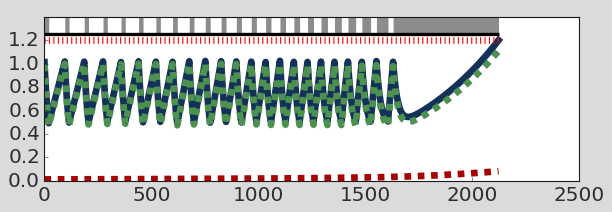

In [6]:
fig, ax = plt.subplots(1,1,figsize=(8,3))

model = StemCellModel(method='Radau', dt = 1)
model.SetParams(**stemParamDic)
model.Simulate_AT(atThreshold=0.5, intervalLength=1, t_end=10000)
model.Trim(dt=1)
model.resultsDf[['TumourSize', 'S', 'R']] /= (stemParamDic['S0'] + stemParamDic['R0'])
model.resultsDf = model.resultsDf[model.resultsDf.TumourSize < 1.2]

print(f"Mean TTP for Stem Cell Model under Adaptive Therapy is {max(model.resultsDf.Time):.0f} days")

palette = {'TumourSize': colors["AT"], 'S': colors['Sensitive'], 'R': colors['Resistant']}
PlotSimulation(model.resultsDf, ax=ax, legend=False, colors = palette, linewidth = 6)

ax.set_xlim(0, 2500)

Mean TTP for Stem Cell Model under Adaptive Therapy is 2235 days


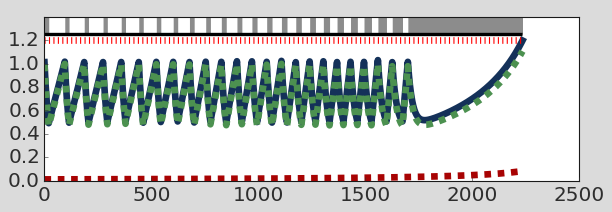

In [7]:
fig, ax = plt.subplots(1,1,figsize=(8,3))

model = StemCellModel2(method='Radau', dt = 1)
model.SetParams(**stemParamDic)
model.Simulate_AT(atThreshold=0.5, intervalLength=1, t_end=10000)
model.Trim(dt=1)
model.resultsDf[['TumourSize', 'S', 'R']] /= (stemParamDic['S0'] + stemParamDic['R0'])
model.resultsDf = model.resultsDf[model.resultsDf.TumourSize < 1.2]

print(f"Mean TTP for Stem Cell Model under Adaptive Therapy is {max(model.resultsDf.Time):.0f} days")

palette = {'TumourSize': colors["AT"], 'S': colors['Sensitive'], 'R': colors['Resistant']}
PlotSimulation(model.resultsDf, ax=ax, legend=False, colors = palette, linewidth = 6)

Mean TTP for Stem Cell Model under Adaptive Therapy is 120 days


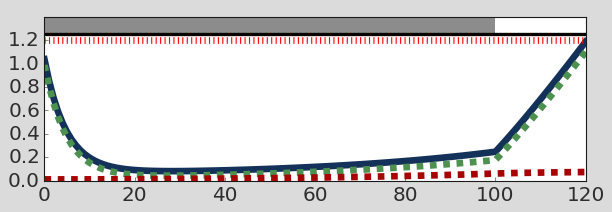

In [44]:
fig, ax = plt.subplots(1,1,figsize=(8,3))

model = StemCellModel(method='Radau', dt = 1)
model.SetParams(**stemParamDic)
model.Simulate_AT(atThreshold=0.5, atMethod='Threshold',
                    intervalLength=100, t_end=1500, refSize = stemParamDic['N0'])
model.Trim(dt=1)
model.resultsDf[['TumourSize', 'S', 'R']] /= (stemParamDic['S0'] + stemParamDic['R0'])
model.resultsDf = model.resultsDf[model.resultsDf.TumourSize < 1.2]

print(f"Mean TTP for Stem Cell Model under Adaptive Therapy is {max(model.resultsDf.Time):.0f} days")

palette = {'TumourSize': colors["AT"], 'S': colors['Sensitive'], 'R': colors['Resistant']}
PlotSimulation(model.resultsDf, ax=ax, legend=False, colors = palette, linewidth = 6)

In [45]:
def calc_ttp(params, n_crit, interval):
    model = StemCellModel(method='Radau', dt = 1); model.SetParams(**params)
    model.Simulate_AT(atThreshold=n_crit, atMethod='Threshold',
                    intervalLength=interval, t_end=1500, refSize = params['N0'])
    model.resultsDf = model.resultsDf[model.resultsDf.TumourSize < 1.2 * params['N0']]
    return model.resultsDf.Time.max()

In [72]:
from scipy.special import lambertw

stemParamDic14 = {'rR': np.log(2),'beta': 0.0425, 'dR': 0.0478,  # Cell params
                'rho': 1.243e-04, 'phi': 0.0113, 'DMax': 1,  # PSA/Drug params
                'S0': 1000, 'R0': 10, 'P0': 11.83}  # Initial conditions

def calc_critical_threshold(tau, rR, beta, S0, N0, **_args):
    lambert_arg = - np.exp(beta - 1.2 * N0 / (S0 * rR * tau)) * N0 / (S0 * rR * tau)
    return 1.2 * N0 * beta * S0 * rR * tau / (1.2 * N0 + S0 * rR * tau * lambertw(lambert_arg).real)

# def calc_critical_threshold(tau, rR, beta, S0, N0, **_args):
#     lambert_arg = - np.exp(beta - 1.2 * N0 / (S0 * rR * tau)) * (N0 / (S0 * rR * tau))
#     return 1.2 * N0 * beta * S0 * rR * tau / (1.2 * N0 )


/var/folders/by/xwl2vmrj5dl9941qxr6lr2t4002mml/T/ipykernel_22981/629779435.py:8: RuntimeWarning: divide by zero encountered in scalar divide
  lambert_arg = - np.exp(beta - 1.2 * N0 / (S0 * rR * tau)) * N0 / (S0 * rR * tau)
/var/folders/by/xwl2vmrj5dl9941qxr6lr2t4002mml/T/ipykernel_22981/629779435.py:8: RuntimeWarning: invalid value encountered in scalar divide
  lambert_arg = - np.exp(beta - 1.2 * N0 / (S0 * rR * tau)) * N0 / (S0 * rR * tau)


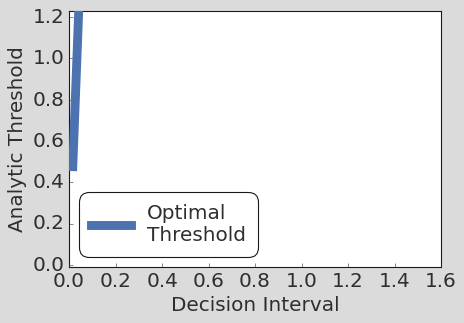

In [73]:
plt.rcParams['font.size'] = '18'
fig, ax = plt.subplots(1,1,figsize=(6,4))

tau_values = np.linspace(0, 1.6, 100)
n_stars = [calc_critical_threshold(tau=t,**stemParamDic) for t in tau_values]
ax.plot(tau_values, n_stars, linewidth = 8, zorder=5, label = 'Optimal\nThreshold'); 



ax.set_ylim(-0.01,1.23); ax.tick_params(right = False, top = False)
plt.gca().legend(loc=3, fontsize=18, numpoints=1, borderaxespad=0.7).get_frame().set_boxstyle('Round', pad=0.2, rounding_size=0.5)
plt.xlabel("Decision Interval"); plt.ylabel("Analytic Threshold");

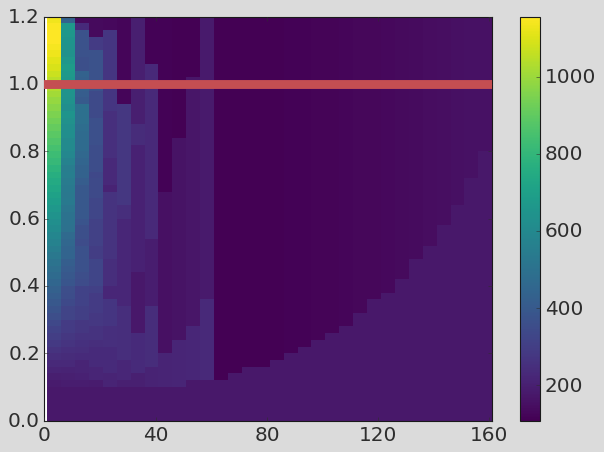

In [48]:
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator



# make these smaller to increase the resolution
dx, dy = 1, 0.01
dx, dy = 5, 0.02
# dx, dy = 40, 0.4

# generate 2 2d grids for the x & y bounds
crit_n_grid, tau_grid = np.mgrid[slice(0, 1.2 + dy, dy),
                slice(1, 161 + dx, dx)]


vectorized_calc_ttp = np.vectorize(calc_ttp)
ttp_values = vectorized_calc_ttp(
    params = stemParamDic, n_crit = crit_n_grid,
    interval = tau_grid
)

ttp_values = ttp_values[:-1, :-1]
fig, ax = plt.subplots()

im = ax.pcolormesh(tau_grid, crit_n_grid, ttp_values, 
                   cmap=plt.get_cmap('viridis'), norm=None)
fig.colorbar(im, ax=ax); #ax.set_title('TTP of Patient 25')

ax.plot(tau_values, n_stars, linewidth = 8, zorder=5, color='r', label = 'Optimal\nThreshold'); 

ax.set_xlim(0, np.max(tau_grid)); 
ax.set_xticks(ax.get_xticks()[::2]); 
fig.tight_layout(); 
plt.savefig("../figures/stem_cell_model_threshold"); plt.show()